# **Time Series Forecasting**

## **Business Understanding**

Nitrogen Dioksida (NO₂) merupakan salah satu gas pencemar udara yang berkontribusi besar terhadap penurunan kualitas udara dan berdampak negatif terhadap kesehatan manusia. Gas ini umumnya dihasilkan dari aktivitas pembakaran bahan bakar fosil, seperti kendaraan bermotor dan industri.
Pemantauan kadar NO₂ secara berkala menjadi penting untuk mengetahui kondisi kualitas udara di suatu wilayah serta memprediksi tren polusi di masa depan.

Sidayu, yang terletak di Kabupaten Gresik, merupakan daerah dengan aktivitas transportasi dan industri yang meningkat. Namun, pengamatan manual terhadap kualitas udara masih terbatas. Oleh karena itu, pemanfaatan data satelit Sentinel-5P yang menyediakan pengukuran konsentrasi NO₂ secara harian dapat menjadi solusi efektif untuk melakukan analisis berbasis data.

## **Data Understanding**

Data yang digunakan merupakan hasil pengukuran harian konsentrasi **Nitrogen Dioksida (NO₂)** di atmosfer.
Produk **SENTINEL_5P_L2** memiliki beberapa band (kanal pengukuran), namun pada penelitian ini hanya digunakan band “NO2” yang menunjukkan konsentrasi gas NO₂ di permukaan bumi dalam satuan µg/m³.

Data diambil berdasarkan **batas wilayah administratif Kecamatan Sidayu, Kabupaten Gresik**, yang didefinisikan menggunakan Area of Interest (AOI) dalam format GeoJSON.

### Penentuan Area of Interest (AOI)

Wilayah kajian ditentukan menggunakan koordinat geografis batas persegi (bounding box) yang mencakup sebagian besar area Kecamatan Sidayu.
Berikut adalah ilustrasi wilayah observasi yang digunakan untuk pengambilan data:

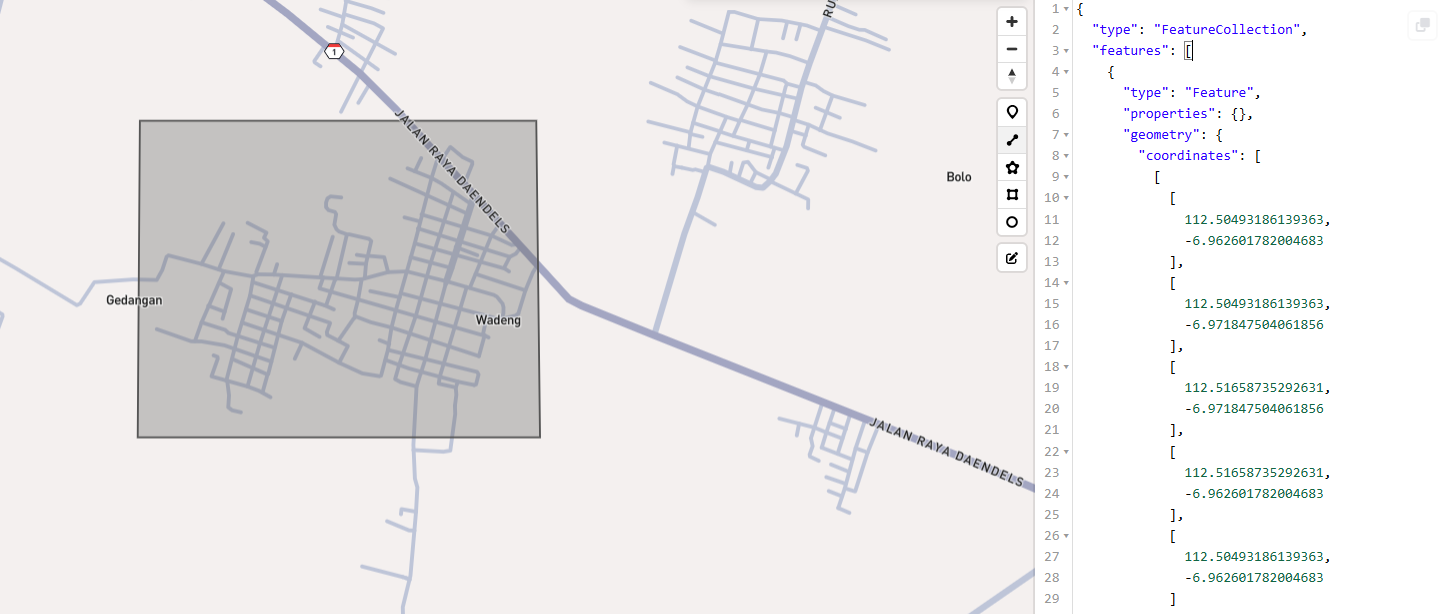

In [1]:
!pip install openeo

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 335.1/335.1 kB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.7/207.7 kB 12.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 27.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.0/88.0 kB 6.4 MB/s eta 0:00:00
  Attempting uninstall: wrapt
    Found existing installation: wrapt 2.0.0
    Uninstalling wrapt-2.0.0:
      Successfully uninstalled wrapt-2.0.0
  Attempting uninstall: xarray
    Found existing installation: xarray 2025.10.1
    Uninstalling xarray-2025.10.1:
      Successfully uninstalled xarray-2025.10.1


In [2]:
import openeo
from shapely.geometry import shape

In [3]:
# Koneksi ke Copernicus Data Space
connection = openeo.connect("openeo.dataspace.copernicus.eu").authenticate_oidc()

Visit https://identity.dataspace.copernicus.eu/auth/realms/CDSE/device?user_code=DIYD-HXHZ 📋 to authenticate.

✅ Authorized successfully

Authenticated using device code flow.


In [4]:
# AOI: poligon kedua dari data kamu (Sidayu, Gresik)
aoi = {
    "type": "Polygon",
    "coordinates": [
        [
            [112.49, -6.94],
            [112.49, -7.02],
            [112.58, -7.02],
            [112.58, -6.94],
            [112.49, -6.94],
        ]
    ],
}

Koordinat tersebut membentuk persegi spasial yang menutupi Desa Gedangan dan Wadeng di Kecamatan Sidayu.
AOI ini digunakan sebagai batas pemrosesan data untuk mengekstraksi nilai rata-rata NO₂ dari citra Sentinel-5P.

### Pengambilan Data Sentinel-5P

Data diambil melalui API openeo.dataspace.copernicus.eu dengan autentikasi **OIDC (OpenID Connect)**.

Kemudian dilakukan pemanggilan koleksi citra `SENTINEL_5P_L2` dengan parameter:

*   `spatial_extent`: batas koordinat AOI (longitude dan latitude),

*   `temporal_extent`: rentang waktu observasi 25 September hingga 25 Oktober 2025,

*   `bands`: hanya menggunakan kanal pengukuran "NO2".

In [5]:
# Ambil data Sentinel-5P (band "NO2")
s5p = connection.load_collection(
    "SENTINEL_5P_L2",
    spatial_extent={
        "west": 112.49,
        "south": -7.02,
        "east": 112.58,
        "north": -6.94,
    },
    temporal_extent=["2025-09-25", "2025-10-25"],
    bands=["NO2"],
)

In [6]:
feature = {"type":"Feature", "geometry": aoi, "properties": {"id": 1}}
fc = {"type": "FeatureCollection", "features": [feature]}

### Proses Agregasi Data



Karena data satelit biasanya merekam beberapa citra dalam satu hari, dilakukan dua tahap agregasi:

*   Agregasi Temporal (harian):
Mengambil rata-rata nilai NO₂ setiap hari (aggregate_temporal_period).

*   Agregasi Spasial:
Mengambil rata-rata seluruh piksel dalam area AOI (aggregate_spatial).



In [7]:
# Now aggregate by day to avoid having multiple data per day
s5p = s5p.aggregate_temporal_period(reducer="mean", period="day")

# let's create a spatial aggregation to generate mean timeseries data
s5p = s5p.aggregate_spatial(reducer="mean", geometries=fc)

### Output Data

Hasil akhir dari proses ini adalah file NetCDF (no2.nc), yang berisi:

*   Tanggal observasi (t)

*   Nilai rata-rata konsentrasi NO₂ (NO2).



In [8]:
job = s5p.execute_batch(title="NO2 Kec. Sidayu, Gresik Sep-Okt 2025", outputfile="no2.nc")

0:00:00 Job 'j-2510250221214cee99a3987d6354decf': send 'start'
0:00:13 Job 'j-2510250221214cee99a3987d6354decf': created (progress 0%)
0:00:19 Job 'j-2510250221214cee99a3987d6354decf': created (progress 0%)
0:00:25 Job 'j-2510250221214cee99a3987d6354decf': created (progress 0%)
0:00:34 Job 'j-2510250221214cee99a3987d6354decf': created (progress 0%)
0:00:44 Job 'j-2510250221214cee99a3987d6354decf': created (progress 0%)
0:00:56 Job 'j-2510250221214cee99a3987d6354decf': running (progress N/A)
0:01:12 Job 'j-2510250221214cee99a3987d6354decf': running (progress N/A)
0:01:32 Job 'j-2510250221214cee99a3987d6354decf': running (progress N/A)
0:01:56 Job 'j-2510250221214cee99a3987d6354decf': finished (progress 100%)


## **Data Preparation**

Tahap Data Preparation bertujuan untuk menyiapkan data mentah hasil ekstraksi dari Sentinel-5P agar siap digunakan dalam proses pemodelan deret waktu (time series forecasting).
Pada tahap ini dilakukan proses konversi format, seleksi atribut, pembersihan data, dan visualisasi awal.

### Konversi Format NetCDF

Setelah proses pengambilan dan agregasi data melalui openEO menghasilkan file no2.nc dalam format NetCDF, format ini perlu diubah menjadi data tabular (DataFrame) agar mudah dianalisis dengan pustaka Python seperti pandas dan matplotlib.

In [9]:
import xarray as xr

In [10]:
# open dataset NetCDF
ds = xr.open_dataset("no2.nc")

# lihat isi untuk menyesuaikan transformasi
print(ds)

df = ds.to_dataframe().reset_index()

# Ambil kolom waktu dan NO2
df = df[['t', 'NO2']]

# Simpan ke CSV
df.to_csv("NO2.csv", index=False)

<xarray.Dataset> Size: 392B
Dimensions:        (t: 23, feature: 1)
Coordinates:
  * t              (t) datetime64[ns] 184B 2025-09-25 2025-09-26 ... 2025-10-24
    lat            (feature) float64 8B ...
    lon            (feature) float64 8B ...
    feature_names  (feature) int64 8B ...
Dimensions without coordinates: feature
Data variables:
    NO2            (feature, t) float64 184B ...
Attributes:
    Conventions:  CF-1.8
    source:       Aggregated timeseries generated by openEO GeoPySpark backend.


Penjelasan:

*   `xarray.open_dataset()` membuka file NetCDF yang berisi data multi-dimensi hasil pemrosesan openEO.

*   `to_dataframe()` mengubah data menjadi format tabel dua dimensi.

*   `reset_index()` memastikan setiap observasi memiliki indeks unik.

*   Kolom `t` (waktu) dan `NO2` (nilai konsentrasi gas) dipilih karena merupakan atribut utama untuk analisis time series.

*   Hasil akhirnya disimpan sebagai `NO2.csv`, yang akan digunakan untuk analisis dan pemodelan selanjutnya.

### Eksplorasi dan Visualisasi Awal Data

Setelah data dalam format CSV siap, langkah selanjutnya adalah melakukan pemeriksaan kualitas data dan visualisasi awal.
Tahapan ini bertujuan untuk melihat pola perubahan nilai NO₂ dari waktu ke waktu dan memastikan tidak ada anomali data.

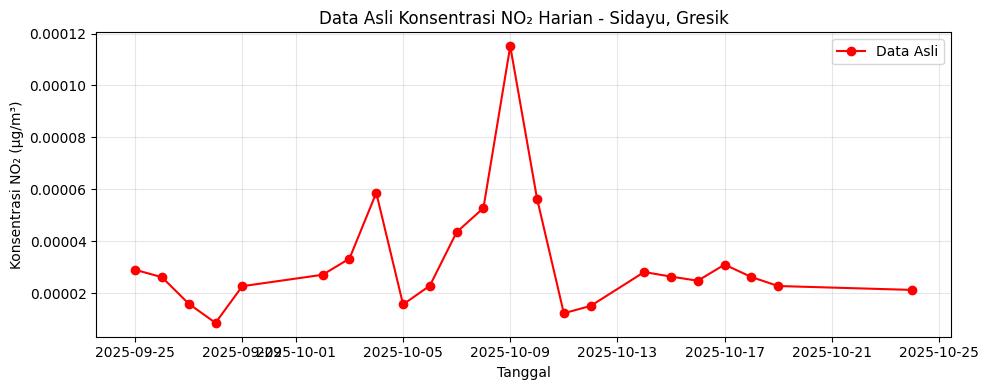

In [11]:
import pandas as pd
import matplotlib.pyplot as plt

# Baca data asli
df_raw = pd.read_csv("NO2.csv")

# Pastikan kolom waktu dalam format datetime
df_raw['t'] = pd.to_datetime(df_raw['t'])

# Plot data NO2
plt.figure(figsize=(10, 4))
plt.plot(df_raw['t'], df_raw['NO2'], color='red', marker='o', linestyle='-', label='Data Asli')

# Label dan judul
plt.xlabel("Tanggal")
plt.ylabel("Konsentrasi NO₂ (µg/m³)")
plt.title("Data Asli Konsentrasi NO₂ Harian - Sidayu, Gresik")
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()

plt.show()


Visual menampilkan grafik garis dengan sumbu-X waktu (tanggal observasi) dan sumbu-Y konsentrasi NO₂, menunjukkan pola variasi harian gas polutan di wilayah Sidayu, Gresik selama periode pengamatan.

In [12]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error, r2_score

### Cek struktur dan tipe data

Digunakan untuk melihat tipe data setiap kolom (terutama kolom waktu t) serta memastikan tidak ada nilai yang hilang atau salah format.

In [13]:
df_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23 entries, 0 to 22
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   t       23 non-null     datetime64[ns]
 1   NO2     23 non-null     float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 500.0 bytes


### Transformasi dan Penyiapan Data Time Series

Pada tahap ini dilakukan proses transformasi data agar data hasil ekstraksi dari Sentinel-5P dapat digunakan sebagai deret waktu (time series) yang siap dianalisis. Langkah-langkah yang dilakukan meliputi konversi kolom waktu ke dalam tipe data datetime, pengurutan data berdasarkan tanggal, serta penetapan kolom waktu sebagai indeks utama.

Langkah-langkah tersebut bertujuan untuk memastikan bahwa struktur data memiliki urutan kronologis yang benar dan kompatibel untuk analisis deret waktu, seperti interpolasi data yang hilang maupun pembentukan fitur historis (lag).

Setelah proses ini, dataset memiliki bentuk yang lebih terstruktur dengan indeks waktu (DatetimeIndex), sehingga dapat digunakan secara optimal pada tahap pemodelan selanjutnya.

In [14]:
# Ubah kolom 't' menjadi tipe datetime
df_raw['t'] = pd.to_datetime(df_raw['t'])
df_raw.info()

no2 = df_raw.copy()

# Urutkan data berdasarkan tanggal
no2 = no2.sort_values('t')

# Set kolom 't' sebagai index
no2 = no2.set_index('t')
print(no2.head(5))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23 entries, 0 to 22
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   t       23 non-null     datetime64[ns]
 1   NO2     23 non-null     float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 500.0 bytes
                 NO2
t                   
2025-09-25  0.000029
2025-09-26  0.000026
2025-09-27  0.000016
2025-09-28  0.000009
2025-09-29  0.000023


### Pemeriksaan kelengkapan tanggal (missing dates)

Langkah ini mengecek apakah ada tanggal yang hilang dari rentang waktu pengamatan.
Jika ada tanggal kosong, maka akan diisi atau diinterpolasi pada tahap berikutnya (misalnya sebelum modeling).

In [15]:
# MEMERIKSA MISSING DATES

# Cek rentang tanggal lengkap (harian)
tanggal_lengkap = pd.date_range(start=no2.index.min(), end="2025-10-25", freq='D')

print(tanggal_lengkap)

# Cari tanggal yang hilang
tanggal_hilang = tanggal_lengkap.difference(no2.index)

print("Tanggal yang hilang:\n", tanggal_hilang)

DatetimeIndex(['2025-09-25', '2025-09-26', '2025-09-27', '2025-09-28',
               '2025-09-29', '2025-09-30', '2025-10-01', '2025-10-02',
               '2025-10-03', '2025-10-04', '2025-10-05', '2025-10-06',
               '2025-10-07', '2025-10-08', '2025-10-09', '2025-10-10',
               '2025-10-11', '2025-10-12', '2025-10-13', '2025-10-14',
               '2025-10-15', '2025-10-16', '2025-10-17', '2025-10-18',
               '2025-10-19', '2025-10-20', '2025-10-21', '2025-10-22',
               '2025-10-23', '2025-10-24', '2025-10-25'],
              dtype='datetime64[ns]', freq='D')
Tanggal yang hilang:
 DatetimeIndex(['2025-09-30', '2025-10-01', '2025-10-13', '2025-10-20',
               '2025-10-21', '2025-10-22', '2025-10-23', '2025-10-25'],
              dtype='datetime64[ns]', freq=None)


## **Pre-Processing**

### Interpolasi dan Penyempurnaan Deret Waktu NO₂

Pada tahap ini dilakukan proses penanganan data hilang (missing value) agar deret waktu (time series) NO₂ memiliki urutan tanggal yang lengkap dan nilai yang kontinu.

Langkah pertama adalah melakukan reindexing terhadap DataFrame agar mencakup seluruh rentang tanggal pengamatan harian dari awal hingga akhir periode (25 September – 25 Oktober 2025). Langkah ini memastikan bahwa setiap hari dalam rentang waktu tersebut memiliki entri, meskipun sebagian nilai awalnya kosong.

Selanjutnya, dilakukan interpolasi linear menggunakan fungsi interpolate(method='linear') untuk mengisi nilai-nilai NO₂ yang hilang berdasarkan tren data sebelumnya dan sesudahnya. Metode interpolasi linear dipilih karena sesuai untuk data lingkungan yang biasanya memiliki perubahan bertahap dari hari ke hari.

Setelah proses interpolasi, kolom indeks dikembalikan menjadi kolom biasa dengan nama date, dan dilakukan pemeriksaan ulang untuk memastikan tidak ada nilai yang masih hilang.

In [16]:
# Reindex dataframe agar semua tanggal muncul
no2 = no2.reindex(tanggal_lengkap)
print(no2.head(10))

# Interpolasi nilai yang hilang (linear interpolation)
no2 = no2.interpolate(method='linear')

# Ubah nama kolom index ke date
no2 = no2.reset_index().rename(columns={'index': 'date'})

# Cek hasil
# print(no2.head())
print("\nJumlah missing value setelah interpolasi:")
print(no2.isna().sum())

                 NO2
2025-09-25  0.000029
2025-09-26  0.000026
2025-09-27  0.000016
2025-09-28  0.000009
2025-09-29  0.000023
2025-09-30       NaN
2025-10-01       NaN
2025-10-02  0.000027
2025-10-03  0.000033
2025-10-04  0.000059

Jumlah missing value setelah interpolasi:
date    0
NO2     0
dtype: int64


Visualisasi juga dibuat untuk membandingkan data asli (yang memiliki missing value) dengan data hasil interpolasi. Dari grafik terlihat bahwa interpolasi menghasilkan deret waktu yang lebih mulus dan kontinu tanpa mengubah pola umum fluktuasi NO₂ harian.

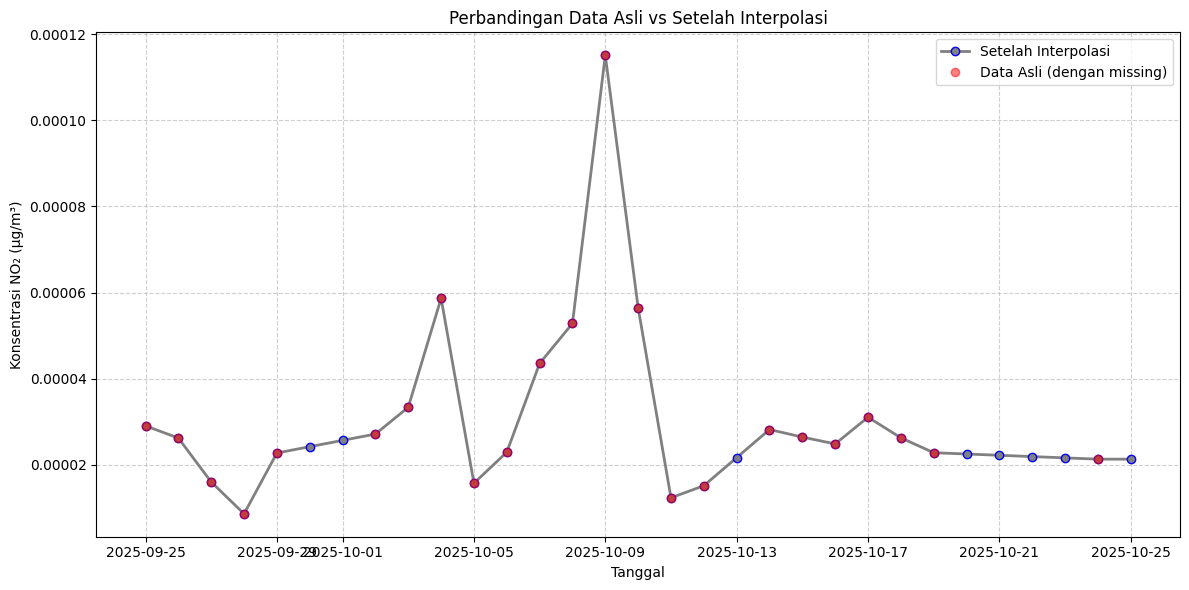

In [17]:
plt.figure(figsize=(12, 6))
plt.plot(no2['date'], no2['NO2'], linestyle='-', color='grey', linewidth=2,  marker='o', markeredgecolor='blue', label='Setelah Interpolasi')
plt.plot(df_raw['t'], df_raw['NO2'], 'ro', alpha=0.5, label='Data Asli (dengan missing)')
plt.title('Perbandingan Data Asli vs Setelah Interpolasi')
plt.xlabel('Tanggal')
plt.ylabel('Konsentrasi NO₂ (µg/m³)')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

### Pembentukan Fitur Time Series (Supervised Framing)

Pada tahap ini, data deret waktu (time series) NO₂ diubah menjadi format supervised learning, agar dapat digunakan oleh model prediksi seperti K-Nearest Neighbors (KNN).

Konsep yang digunakan disebut lag features, yaitu membuat fitur dari nilai-nilai NO₂ pada hari-hari sebelumnya untuk memprediksi nilai hari berikutnya. Dalam kode berikut, dibuat tiga kolom baru:

*   h-3: nilai NO₂ tiga hari sebelumnya,

*   h-2: dua hari sebelumnya, dan

*   h-1: satu hari sebelumnya,

*   sementara kolom t berisi nilai NO₂ pada hari yang akan diprediksi.

Proses ini menggunakan fungsi shift() untuk menggeser data sesuai urutan waktu. Setelah itu, baris yang memiliki nilai kosong akibat pergeseran data dihapus menggunakan dropna().

In [18]:
supervised = pd.DataFrame()
supervised['h-3'] = no2['NO2'].shift(3)
supervised['h-2'] = no2['NO2'].shift(2)
supervised['h-1'] = no2['NO2'].shift(1)
supervised['t'] = no2['NO2']

In [19]:
supervised = supervised.dropna().reset_index(drop=True)
print(supervised.head())

        h-3       h-2       h-1         t
0  0.000029  0.000026  0.000016  0.000009
1  0.000026  0.000016  0.000009  0.000023
2  0.000016  0.000009  0.000023  0.000024
3  0.000009  0.000023  0.000024  0.000026
4  0.000023  0.000024  0.000026  0.000027


### Normalisasi Data dengan Min-Max Scaler

Setelah data dibentuk ke dalam format supervised, dilakukan proses normalisasi menggunakan metode Min-Max Scaling.
Tujuan dari normalisasi adalah untuk menyamakan skala antar fitur, karena setiap kolom (misalnya h-3, h-2, h-1, dan t) bisa memiliki rentang nilai yang berbeda.

In [20]:
scaler = MinMaxScaler(feature_range=(0, 1))

scaled_values = scaler.fit_transform(supervised)
scaled = pd.DataFrame(scaled_values, columns=supervised.columns)

print(scaled.head())

        h-3       h-2       h-1         t
0  0.191864  0.165194  0.069307  0.000000
1  0.165194  0.069307  0.000000  0.132610
2  0.069307  0.000000  0.132610  0.146375
3  0.000000  0.132610  0.146375  0.160141
4  0.132610  0.146375  0.160141  0.173906


## **Modeling**

### Pembagian Data untuk Pelatihan dan Pengujian

Langkah ini membagi dataset menjadi dua bagian, yaitu data latih (train) dan data uji (test) dengan perbandingan 70:30.
Data latih digunakan untuk melatih model agar dapat mengenali pola dari data historis, sedangkan data uji digunakan untuk mengukur kemampuan model dalam melakukan prediksi terhadap data baru.

Parameter shuffle=False digunakan karena data ini merupakan time series, sehingga urutan waktu harus dipertahankan agar model tidak kehilangan konteks temporalnya.

In [21]:
X = scaled.drop('t', axis=1)
y = scaled['t']

In [22]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, shuffle=False)

### Model K-Nearest Neighbors (KNN)

Model **K-Nearest Neighbors (KNN) Regression** digunakan untuk memprediksi konsentrasi NO₂ berdasarkan nilai-nilai historis beberapa hari sebelumnya (`h-3, h-2, h-1`).
Nilai `k` = 7 dipilih untuk mempertimbangkan tujuh tetangga terdekat dalam menentukan prediksi.

Evaluasi model dilakukan menggunakan dua metrik:

*   Mean Squared Error (MSE): mengukur rata-rata kesalahan kuadrat antara nilai aktual dan prediksi.

*   R² Score: menunjukkan seberapa baik model mampu menjelaskan variasi dalam data (semakin mendekati 1, semakin baik).



In [23]:
knn = KNeighborsRegressor(n_neighbors=7)
knn.fit(X_train, y_train)

y_pred = knn.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f'Mean Squared Error: {mse:.4f}')
print(f'R² Score: {r2:.4f}')

Mean Squared Error: 0.0037
R² Score: -3.5775


### Hasil Prediksi dan Evaluasi

Bagian ini menampilkan perbandingan antara nilai aktual dan hasil prediksi dari model KNN untuk data uji.
Hasil ini berguna untuk menilai sejauh mana model mampu meniru pola dari data historis. Jika nilai prediksi mendekati nilai aktual, berarti model bekerja dengan baik.

In [24]:
result = pd.DataFrame({
    'Actual': y_test,
    'Predicted': y_pred
}).reset_index(drop=True)

print("\nContoh hasil prediksi:")
print(result.head())


Contoh hasil prediksi:
     Actual  Predicted
0  0.210646   0.189786
1  0.165754   0.230148
2  0.133216   0.193719
3  0.130402   0.189786
4  0.127587   0.189786


### Prediksi Hari Berikutnya

Langkah ini menggunakan data tiga hari terakhir sebagai input untuk memprediksi konsentrasi NO₂ pada hari berikutnya.
Karena model dilatih dengan data yang telah dinormalisasi, hasil prediksi kemudian di-invers kembali ke skala aslinya menggunakan scaler.inverse_transform() agar nilainya dapat diinterpretasikan secara realistis.

In [25]:
last_input = scaled.drop('t', axis=1).iloc[-1].values.reshape(1, -1)
next_pred_scaled = knn.predict(last_input)
next_pred = scaler.inverse_transform(
    np.hstack((last_input, next_pred_scaled.reshape(-1, 1)))
)[0, -1]

# Buat tanggal baru untuk prediksi
next_date = (pd.to_datetime(no2['date'].iloc[-1]) + pd.Timedelta(days=1)).date()

print(f'\nPrediksi NO2 pada {next_date}: {next_pred}')


Prediksi NO2 pada 2025-10-26: 2.4875606067369175e-05


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but KNeighborsRegressor was fitted with feature names
  warnings.warn(


### Visualisasi Hasil Prediksi

Visualisasi ini menampilkan tren data NO₂ aktual bersama dengan titik prediksi untuk hari berikutnya.
Garis biru menunjukkan nilai historis yang diperoleh dari hasil interpolasi, sementara titik merah menunjukkan hasil prediksi model.
Visualisasi ini memudahkan interpretasi terhadap pola data dan posisi nilai prediksi terhadap tren sebelumnya.

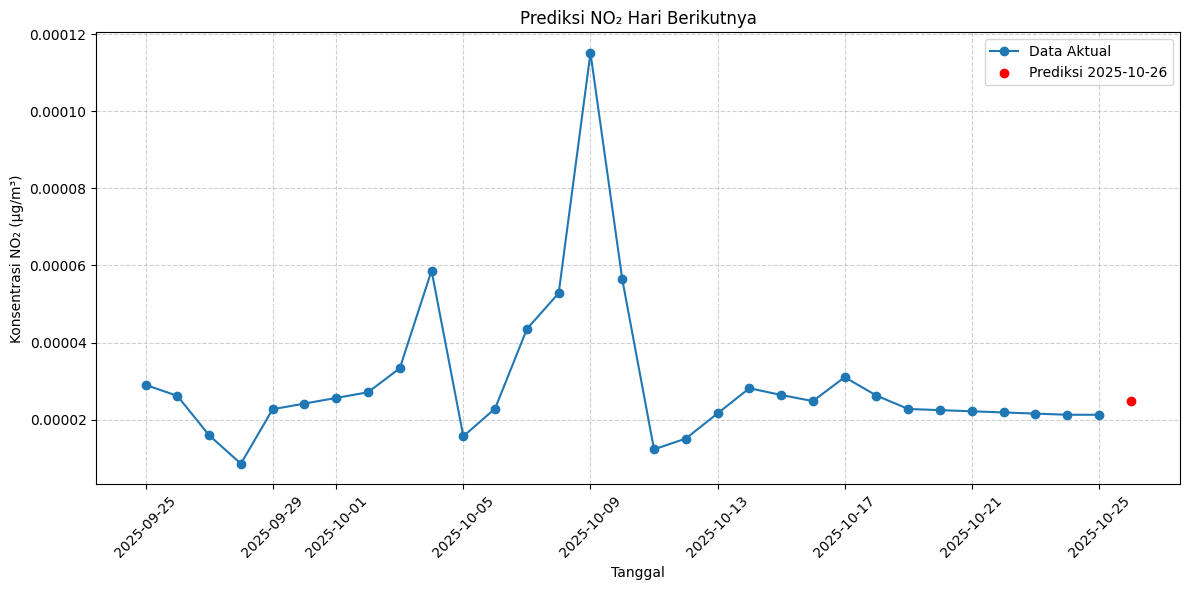

In [26]:
plt.figure(figsize=(12, 6))
plt.plot(no2['date'], no2['NO2'], marker='o', label='Data Aktual')
plt.scatter(next_date, next_pred, color='red', label=f'Prediksi {next_date}')

plt.title('Prediksi NO₂ Hari Berikutnya')
plt.xlabel('Tanggal')
plt.ylabel('Konsentrasi NO₂ (µg/m³)')
plt.xticks(rotation=45)
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()